## 收集数据

In [1]:
import pandas as pd
import numpy as np
import requests
import json

In [2]:
# 收集推特图像的预测数据
url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/数据清洗/WeRateDogs项目/image-predictions.tsv"
response = requests.get(url)
with open("image-predictions.tsv", "w") as fb:
    fb.write(response.text)

In [3]:
# 三个文件收集完毕，现在将数据读如 DataFrame
df_arc = pd.read_csv("twitter-archive-enhanced.csv")
df_img = pd.read_csv("image-predictions.tsv", sep="\t")
extra_json = []
with open("tweet_json.txt", "r") as f:
    for line in f:
        extra_json.append(json.loads(line))

df_api = pd.DataFrame.from_dict(extra_json)

## 评估数据

In [4]:
df_arc.query("rating_denominator != 10").head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [5]:
df_api.query("id==835246439529840640").head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
310,None,None,Fri Feb 24 21:54:03 +0000 2017,"[22, 98]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,2248,False,@jonnysun @Lin_Manuel ok jomny I know you're e...,None,...,NaN,NaN,NaN,NaN,82,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [6]:
df_arc["name"].isnull().sum()

0

#### 质量
1. `twitter-archive-enhanced.csv`: `rating_denominator` 有些是 10，有些不是 10
2. `twitter-archive-enhanced.csv`: `rating_numerator` 缺少小数点精度
3. `twitter-archive-enhanced.csv`: `name` 大小写不统一
4. `twitter-archive-enhanced.csv`: `name=None` 未识别成 NaN
5. `twitter-archive-enhanced.csv`: `tweet_id` 类型是 int，应该是 str
6. `twitter-archive-enhanced.csv`: 有些狗狗存在两个stage（如tweet_id=854010172552949760）
7. `twitter-archive-enhanced.csv`: 狗狗分类 `None` 未识别成 NaN
8. `tweet_json.txt`: `display_text_range` 类型是 list，应该是 int

#### 清洁度
1. 狗狗的 `Stage` 用了四列来表示（doggo, floofer, pupper, puppo）
2. 三个数据集都是以 `tweet_id` 为观察单位，需要合并成一个表

## 清理数据

In [7]:
cleaned_df_arc = df_arc.copy()
cleaned_df_api = df_api.copy()
cleaned_df_img = df_img.copy()

In [8]:
cleaned_df_arc.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### 质量

##### 1. `rating_denominator` 有些是 10，有些不是 10

##### 定义
将分母设置成 10

##### 代码

In [9]:
cleaned_df_arc['rating_denominator'] = 10

##### 测试

In [10]:
cleaned_df_arc['rating_denominator'].value_counts()

10    2356
Name: rating_denominator, dtype: int64

##### 2. `rating_numerator` 缺少小数点精度

##### 定义
重新提取狗狗评分的分子 `rating_numerator`

##### 代码

In [11]:
rating = cleaned_df_arc.text.str.extract(r'(\d+\.?\d+)\/10', expand=True)
cleaned_df_arc["rating_numerator"] = rating.astype(float)

##### 测试

In [12]:
cleaned_df_arc['rating_numerator'].value_counts()

12.00      558
11.00      466
10.00      463
13.00      354
14.00       56
9.75         2
420.00       2
15.00        2
13.50        1
17.00        1
182.00       1
1776.00      1
9.50         1
11.26        1
11.27        1
666.00       1
7.00         1
Name: rating_numerator, dtype: int64

#### 3. `name` 大小写不统一

##### 定义
将 `name` 为小写的狗狗名字改成 NaN

##### 代码

In [13]:
cleaned_df_arc.loc[cleaned_df_arc.name.str.islower(), "name"] = 'None'

##### 测试

In [14]:
cleaned_df_arc[cleaned_df_arc.name.str.islower()].name.value_counts()

Series([], Name: name, dtype: int64)

#### 4. `name=None` 没识别成 NaN

##### 定义
将名字是 `None` 狗狗名字标志成 NaN

##### 代码

In [15]:
cleaned_df_arc.loc[cleaned_df_arc.name == "None", "name"] = np.nan

##### 测试

In [16]:
len(cleaned_df_arc.query("name=='None'"))

0

#### 5. `tweet_id` 类型是 int，应该是 str

##### 定义
将 `tweet_id` 的数据类型转成 `str`

##### 代码

In [17]:
cleaned_df_arc["tweet_id"] = cleaned_df_arc.astype("str")

##### 测试

In [18]:
cleaned_df_arc.dtypes

tweet_id                       object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator              float64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

##### 6. `twitter-archive-enhanced.csv`: 有些狗狗存在两个stage（如tweet_id=854010172552949760）

##### 定义
将包含两个 `stage` 的狗狗，默认值保留第一个 `stage`

##### 代码

In [19]:
cleaned_df_arc.loc[cleaned_df_arc.query("doggo!='None' and floofer!='None'").index, 'floofer'] = 'None'
cleaned_df_arc.loc[cleaned_df_arc.query("doggo!='None' and pupper!='None'").index, 'pupper'] = 'None'
cleaned_df_arc.loc[cleaned_df_arc.query("doggo!='None' and puppo!='None'").index, 'puppo'] = 'None'

##### 测试

In [20]:
cleaned_df_arc.query("doggo!='None' and floofer!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [21]:
cleaned_df_arc.query("doggo!='None' and pupper!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [22]:
cleaned_df_arc.query("doggo!='None' and puppo!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [23]:
cleaned_df_arc.query("floofer!='None' and pupper!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [24]:
cleaned_df_arc.query("floofer!='None' and puppo!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [25]:
cleaned_df_arc.query("pupper!='None' and puppo!='None'")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


##### 7. `twitter-archive-enhanced.csv`: 狗狗分类 `None` 未识别成 NaN

##### 定义
将狗狗分类是 `None` 的改成 NaN

##### 代码

In [26]:
cleaned_df_arc.loc[cleaned_df_arc.query("doggo=='None'").index, "doggo"] = np.nan
cleaned_df_arc.loc[cleaned_df_arc.query("floofer=='None'").index, "floofer"] = np.nan
cleaned_df_arc.loc[cleaned_df_arc.query("pupper=='None'").index, "pupper"] = np.nan
cleaned_df_arc.loc[cleaned_df_arc.query("puppo=='None'").index, "puppo"] = np.nan

##### 测试

In [27]:
len(cleaned_df_arc.query("doggo=='None'"))

0

In [28]:
len(cleaned_df_arc.query("floofer=='None'"))

0

In [29]:
len(cleaned_df_arc.query("pupper=='None'"))

0

In [30]:
len(cleaned_df_arc.query("puppo=='None'"))

0

##### 8. `tweet_json.txt`: `display_text_range` 类型是 list，应该是 int

##### 定义
`display_text_range` 应该是 int 类型，取 list 的第二个元素

##### 代码

In [31]:
ranges = cleaned_df_api["display_text_range"].str[1]
cleaned_df_api["display_text_range"] = ranges.astype(int)

##### 测试

In [32]:
cleaned_df_api["display_text_range"][:5]

0     85
1    138
2    121
3     79
4    138
Name: display_text_range, dtype: int64

#### 清洁度

##### 1. 狗狗的 `Stage` 用了四列来表示（doggo, floofer, pupper, puppo）

##### 定义
将狗狗的 `Stage` 合并成一列

##### 代码

In [33]:
stages = []
for index, row in cleaned_df_arc.iterrows():
    cat = np.nan
    for stage in ['doggo', 'floofer', 'pupper', 'puppo']:
        if row[stage] == stage:
            cat = stage
            break
    stages.append(cat)
cleaned_df_arc['stage'] = stages
cleaned_df_arc['stage'] = cleaned_df_arc['stage'].astype('category')

In [34]:
cleaned_df_arc["stage"].value_counts()

pupper     245
doggo       97
puppo       29
floofer      9
Name: stage, dtype: int64

In [35]:
cleaned_df_arc.query("tweet_id=='886366144734445568'")
# cleaned_df_arc.head()
# cleaned_df_arc.dtypes

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12.0,10,Roscoe,NaN,NaN,pupper,NaN,pupper


##### 2. 三个数据集都是以 `tweet_id` 为观察单位，需要合并成一个表

In [36]:
# 合并成一个 DataFrame
cleaned_df_arc['tweet_id'] = cleaned_df_arc['tweet_id'].astype('int64')
cleaned_df_api.rename(columns={'id': 'tweet_id'}, inplace=True)
merged_df = cleaned_df_arc[['tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', 'name', 'stage']].merge(
    cleaned_df_api[['tweet_id', 'display_text_range', 'favorite_count', 'retweet_count']], on = 'tweet_id'
).merge(
    cleaned_df_img[['tweet_id', 'p1', 'p1_conf', 'p1_dog']], on = 'tweet_id'
)

In [37]:
# 检测
merged_df.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stage,display_text_range,favorite_count,retweet_count,p1,p1_conf,p1_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,85,39492,8842,orange,0.097049,False


##### 3. 将数据集设置成时序索引

In [38]:
merged_df['datetime'] = pd.to_datetime(merged_df['timestamp'], format='%Y-%m-%d %H:%M:%S %z')
merged_df = merged_df.set_index('datetime')
merged_df.drop(['timestamp'], axis=1, inplace=True)
merged_df.index

DatetimeIndex(['2017-08-01 16:23:56+00:00', '2017-08-01 00:17:27+00:00',
               '2017-07-31 00:18:03+00:00', '2017-07-30 15:58:51+00:00',
               '2017-07-29 16:00:24+00:00', '2017-07-29 00:08:17+00:00',
               '2017-07-28 16:27:12+00:00', '2017-07-28 00:22:40+00:00',
               '2017-07-27 16:25:51+00:00', '2017-07-26 15:59:51+00:00',
               ...
               '2015-11-16 01:01:59+00:00', '2015-11-16 00:55:59+00:00',
               '2015-11-16 00:49:46+00:00', '2015-11-16 00:35:11+00:00',
               '2015-11-16 00:30:50+00:00', '2015-11-16 00:24:50+00:00',
               '2015-11-16 00:04:52+00:00', '2015-11-15 23:21:54+00:00',
               '2015-11-15 23:05:30+00:00', '2015-11-15 22:32:08+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=2073, freq=None)

In [39]:
# pd.to_datetime(cleaned_df_arc['timestamp'])
# type(cleaned_df_arc['timestamp'][0])
# pd.to_datetime(cleaned_df_arc['timestamp'][1])
# pd.to_datetime(cleaned_df_arc.timestamp)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2073 entries, 2017-08-01 16:23:56+00:00 to 2015-11-15 22:32:08+00:00
Data columns (total 12 columns):
tweet_id              2073 non-null int64
text                  2073 non-null object
rating_numerator      1652 non-null float64
rating_denominator    2073 non-null int64
name                  1396 non-null object
stage                 321 non-null category
display_text_range    2073 non-null int64
favorite_count        2073 non-null int64
retweet_count         2073 non-null int64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
dtypes: bool(1), category(1), float64(2), int64(5), object(3)
memory usage: 182.4+ KB


In [40]:
# 保存到 CSV 文件
merged_df.to_csv('cleaned_tweets.csv')

In [41]:
df = pd.read_csv('cleaned_tweets.csv', index_col = 'datetime')
df.head(5)

,tweet_id,text,rating_numerator,rating_denominator,name,stage,display_text_range,favorite_count,retweet_count,p1,p1_conf,p1_dog
datetime,,,,,,,,,,,,
2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,85,39492,8842,orange,0.097049,False
2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,138,33786,6480,Chihuahua,0.323581,True
2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,121,25445,4301,Chihuahua,0.716012,True
2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,79,42863,8925,paper_towel,0.170278,False
2017-07-29 16:00:24+00:00,891327558926688256,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,138,41016,9721,basset,0.555712,True


## 数据探索分析

In [42]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df = pd.read_csv('cleaned_tweets.csv', index_col = 'datetime', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2073 entries, 2017-08-01 16:23:56+00:00 to 2015-11-15 22:32:08+00:00
Data columns (total 12 columns):
tweet_id              2073 non-null int64
text                  2073 non-null object
rating_numerator      1652 non-null float64
rating_denominator    2073 non-null int64
name                  1396 non-null object
stage                 321 non-null object
display_text_range    2073 non-null int64
favorite_count        2073 non-null int64
retweet_count         2073 non-null int64
p1                    2073 non-null object
p1_conf               2073 non-null float64
p1_dog                2073 non-null bool
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 196.4+ KB


/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left == right == 10.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom == top == 10.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left == right == 10.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


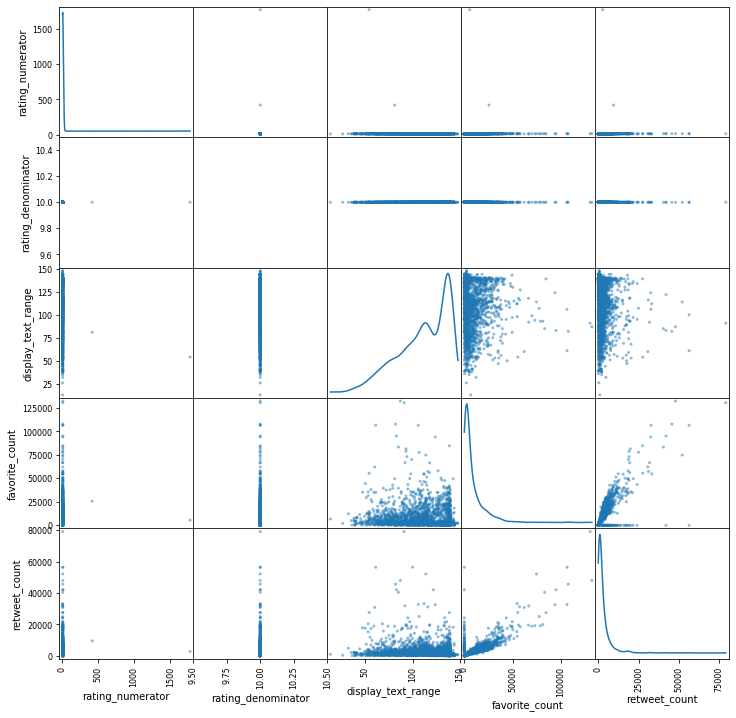

In [43]:
lis = ['rating_numerator', 'rating_denominator', 'display_text_range', 'favorite_count', 'retweet_count']
scatter_matrix(df[lis], figsize=(12, 12), diagonal='kde');

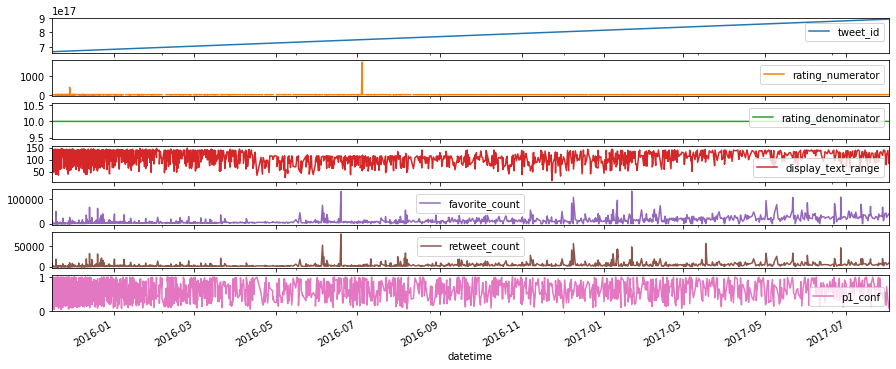

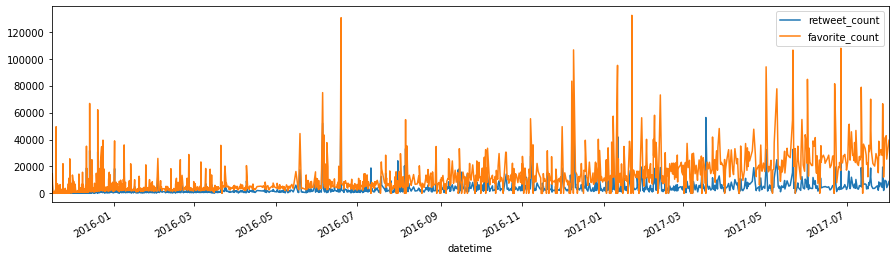

In [44]:
df.plot(subplots=True, figsize=(15, 6))
df.plot(y=['retweet_count', 'favorite_count'], figsize=(15,4))

/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


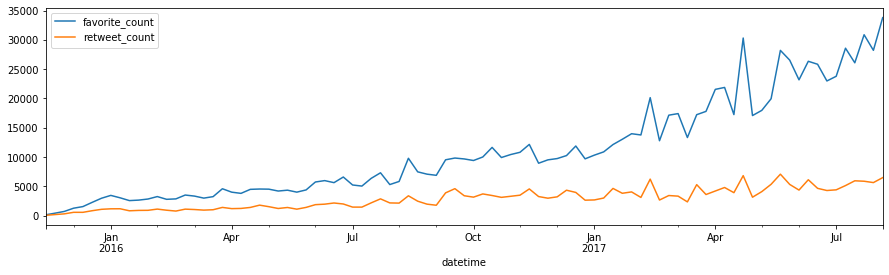

In [45]:
df[['favorite_count', 'retweet_count']].resample("1w").median().plot(figsize=(15,4))

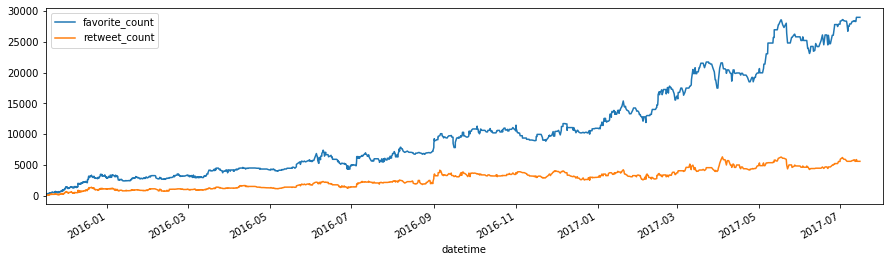

In [46]:
df[['favorite_count', 'retweet_count']].rolling(30).median().plot(figsize=(15,4))

## 得出结论

### `favorite_count` 和 `retweet_count` 的时序分析

Text(0, 0.5, 'Counts')

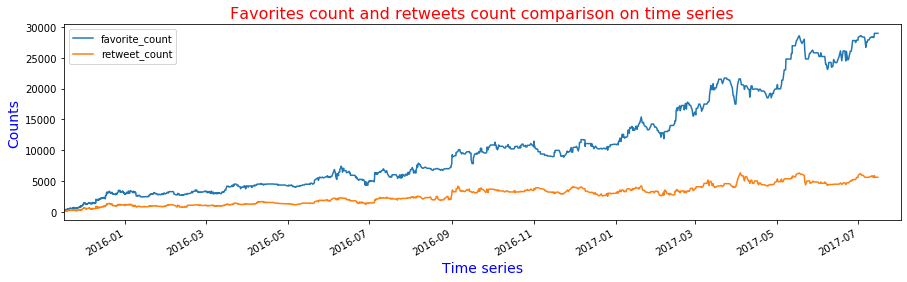

In [47]:
df[['favorite_count', 'retweet_count']].rolling(30).median().plot(figsize=(15,4))

plt.title('Favorites count and retweets count comparison on time series', color='r', fontsize=16)
plt.xlabel('Time series', color='b', fontsize=14)
plt.ylabel('Counts', color='b', fontsize=14)

- 2016年7月之前的喜欢数大概是转发数的两倍
- 2016年7月后喜欢数出现了爆发式增长，同时转发数量持续缓慢增长
- twitter 的增长很快
- 人们更愿意用点赞的方式来进行 social，而非成本更高的转发

### `favorite_count` 和 `retweet_count` 相关性分析

/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:407: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/Users/xuncheng/.anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:415: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


Text(0, 0.5, 'Retweets Count')

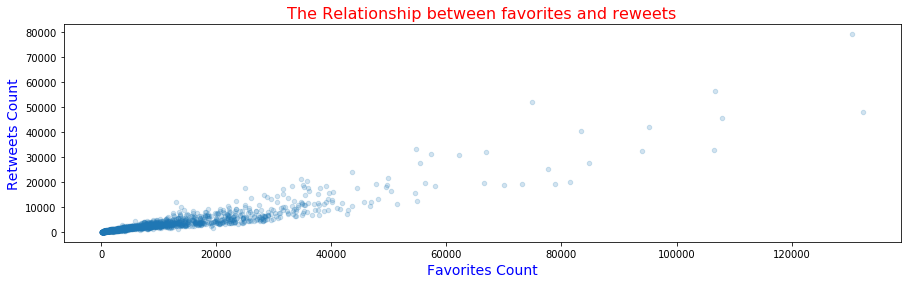

In [48]:
df.query('favorite_count > 0').plot.scatter(x='favorite_count', y='retweet_count', alpha=0.2, figsize=(15,4))

plt.title('The Relationship between favorites and reweets', color='r', fontsize=16)
plt.xlabel('Favorites Count', color='b', fontsize=14)
plt.ylabel('Retweets Count', color='b', fontsize=14)

- 可以看出喜欢数和转发数直接存在着相关性